In [21]:
import numpy as np
import matplotlib.pyplot as plt
import src.math_tool as mt
import src.img_tool as it
import src.apertures as apertures
from PIL import Image
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
ideal_img = Image.open('./aperture/f49f33_angular8.bmp')
approx_man_file = np.array(ideal_img.resize((512, 512), Image.LANCZOS))
ideal_img = np.array(ideal_img)
ideal_img = (ideal_img > 255/2)
def denoise(img):
    '''
    img <2+d array> Nx, Ny, ...
    '''
    rolls = np.array([np.roll(img, 1, axis=0), np.roll(img, -1, axis=0), np.roll(img, 1, axis=1), np.roll(img, -1, axis=1)])# *1 # no corner
    # print(scale_up*1 + scale_up_rolls_corner[3])
    output = img.copy()
    output += rolls[0] * rolls[1] # dig hole if both up and down is dug
    output += rolls[2] * rolls[3] # dig hole if both left and right is dug
    return output
def corrode(man_img): # corrode to make the pass through hole bigger
    scale_up = np.repeat(man_img, 2, axis=0)
    scale_up = np.repeat(scale_up, 2, axis=1)
    scale_up_rolls = np.array([np.roll(scale_up, 1, axis=0), np.roll(scale_up, -1, axis=0), np.roll(scale_up, 1, axis=1), np.roll(scale_up, -1, axis=1)])# *1 # no corner
    scale_up_rolls_corner = np.array([np.roll(scale_up_rolls[0], 1, axis=1), np.roll(scale_up_rolls[1], -1, axis=1), np.roll(scale_up_rolls[2], -1, axis=0), np.roll(scale_up_rolls[3], 1, axis=0)]) #*10 # pure corner
    # print(scale_up*1 + scale_up_rolls_corner[3])
    output = scale_up.copy()
    for i in range(4):
        output += scale_up_rolls[i] + scale_up_rolls_corner[i]
    return output
thres = np.linspace(0, 255, 256, endpoint=True)
man_file = approx_man_file[:, :, None] > thres # Nx/2, Ny/2, N_thres
man_file = denoise(man_file) # Nx/2, Ny/2, N_thres
man_file = denoise(man_file) # Nx/2, Ny/2, N_thres
produced = corrode(man_file) # Nx, Ny, N_thres
diff = ideal_img[:,:,None]*1 - produced*1
MSD = np.abs(diff).sum(axis=(0,1))
print(MSD)
idx = np.argmin(MSD)
man_file = man_file[..., idx]
produced = produced[..., idx]
diff = diff[..., idx]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[189820 162284 155144 130088 116392  81988  79236  77684  77524  76912
  76064  75312  74272  73588  68116  66940  65876  65652  63732  62736
  61112  60456  59872  59576  59556  59556  59548  59464  59448  59444
  59440  59440  59440  59440  59440  59440  59436  59436  59436  59436
  59436  59436  59436  59436  59436  59436  59436  59436  59436  59436
  59436  59436  59432  59432  59432  59428  59424  59420  59416  59400
  58828  58488  57992  57424  57372  57272  57248  57248  56752  56044
  54468  52980  52636  52348  51252  49824  49216  48364  47980  47952
  47952  47944  47928  47916  47916  47904  47904  47888  47888  47888
  47888  47888  47888  47888  47888  47888  47888  47888  47888  47888
  47888  47888  47888  47888  47888  47888  47888  47884  47872  47868
  47852  47604  47172  47144  47136  47128  47100  47060  47056  46788
  46736  45508  45200  44812  44776  44716  44508  38892  37

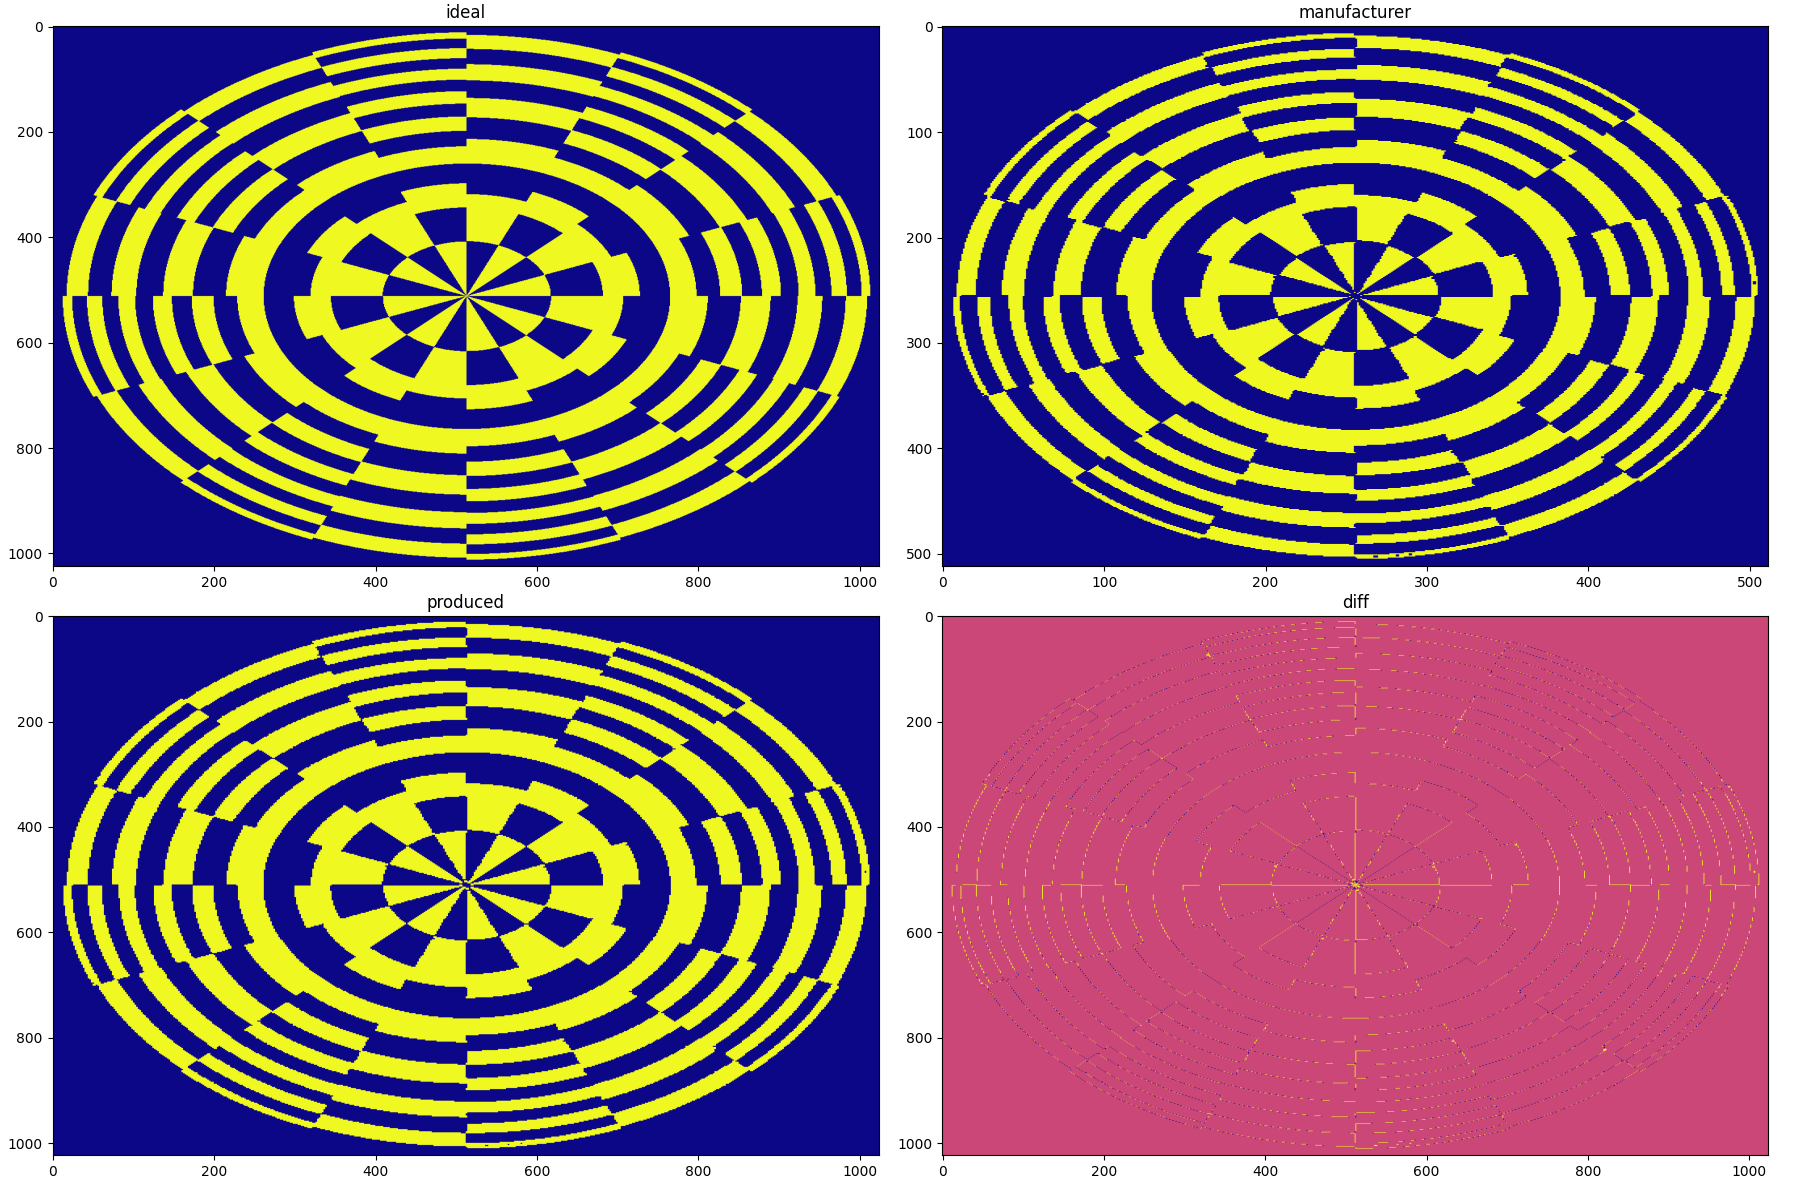

In [22]:
layout = [[0, 1], [2, 3]]
fig, ax = plt.subplot_mosaic(layout, figsize=(18,12))
title = ['ideal', 'manufacturer', 'produced', 'diff']
image = [ideal_img, man_file, produced, diff]
fig.tight_layout(pad=1.5)
for i in range(len(title)):
    ax[i].imshow(image[i], aspect='auto', cmap='plasma')
    ax[i].set_title(title[i])

<PIL.Image.Image image mode=1 size=512x512 at 0x7B71B59CFFB0>
15490
previous error: 15548


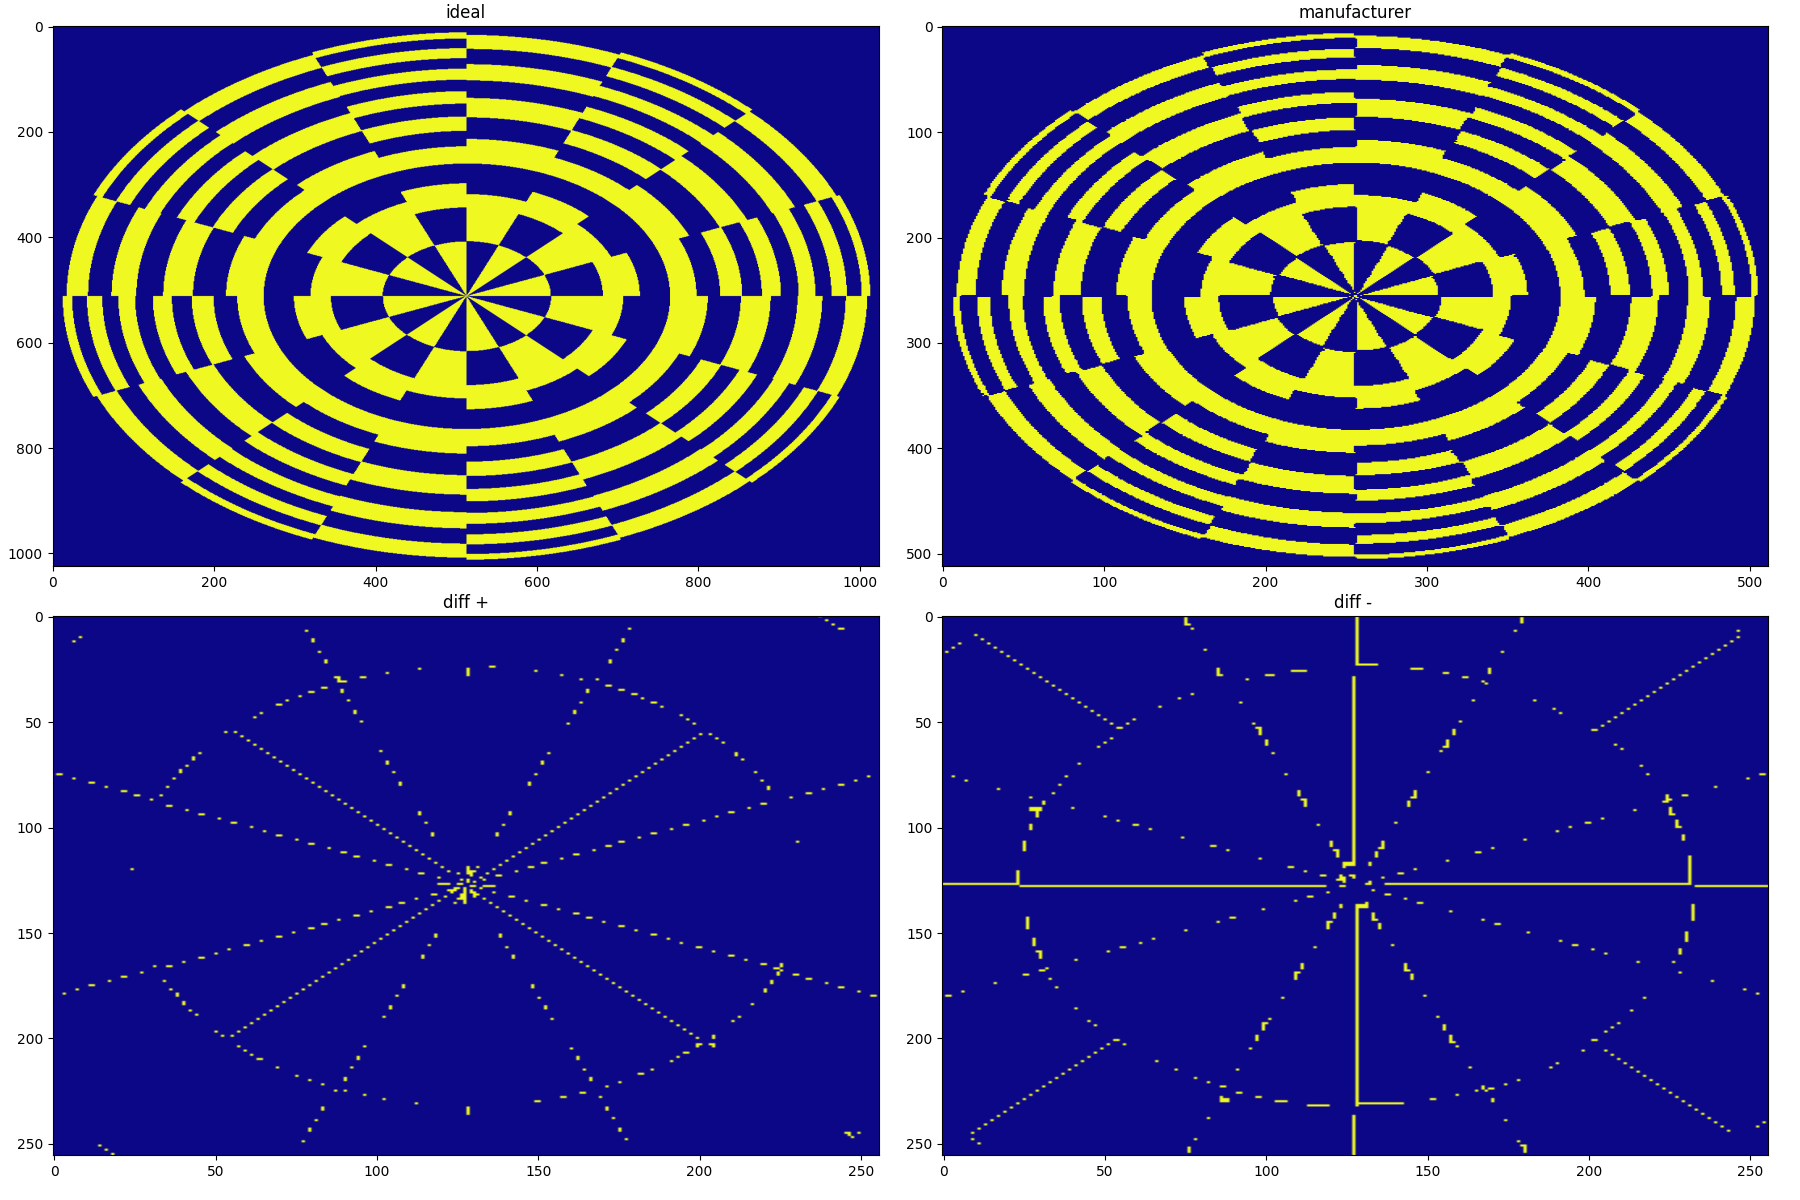

In [39]:
# print(man_file)
# # start manual correction after optimize along interpolation
img = Image.fromarray(man_file)
print(img)
img.save('./aperture/tmp/man_file.bmp')
# open manual corrected file
man_file2 = np.array(Image.open('./aperture/tmp/man_file_edit.bmp'))
produced2 = corrode(man_file2)
diff2 = produced2*1 - ideal_img*1
layout = [[0, 1], [2, 3]]
fig, ax = plt.subplot_mosaic(layout, figsize=(18,12))
title = ['ideal', 'manufacturer', 'diff +', 'diff - ']
image = [ideal_img, man_file2, diff2[384:-384, 384:-384] > 0, diff2[384:-384, 384:-384] < 0]
fig.tight_layout(pad=1.5)
for i in range(len(title)):
    ax[i].imshow(image[i], aspect='auto', cmap='plasma')
    ax[i].set_title(title[i])
MSD2 = np.abs(diff2).sum(axis=(0,1))
print(MSD2)
print(f'previous error: {MSD.min()}')

In [43]:
man_file3 = np.array(Image.open('./aperture/man_file_edit_15490_binary.bmp'))
print(man_file3.shape)
man_file_out = man_file3[6:-6, 6:-6]
print(man_file_out.shape)
# img = Image.fromarray(man_file3)
# print(img)
# img.save('./aperture/tmp/man_file.bmp')
# # open manual corrected file


(512, 512)
(500, 500)


In [47]:
img = Image.fromarray(man_file_out)
# print(img)
img.save('./aperture/tmp/man_file_out_binary.bmp')
tmp = (man_file_out * 255).astype(np.uint8)
img = Image.fromarray(tmp)
print(img)
img.save('./aperture/tmp/man_file_out_8bit.bmp')
img = Image.fromarray(np.repeat(tmp[:, :, None], 3, axis=2))
print(img)
img.save('./aperture/tmp/man_file_out_full_color.bmp')

<PIL.Image.Image image mode=L size=500x500 at 0x7B71B57C33B0>
<PIL.Image.Image image mode=RGB size=500x500 at 0x7B71B605BFE0>


In [50]:
man_file_inverted = np.array(Image.open('./aperture/tmp/man_file_15490_binary.bmp'))
print(man_file_inverted)
img = Image.fromarray(man_file_out == False)
img.save('./aperture/tmp/man_file_15490_binary_inverted.bmp')

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
